## 필요 라이브러리

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import re

from pyspark.sql.functions import col, to_timestamp
import pymysql
import mysql.connector
import pandas as pd
from kiwi import kiwi
from kiwipiepy import Kiwi
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Kkma
#from umap.umap_ import UMAP
#import hdbscan
#from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.sql.functions import col, to_timestamp
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
import torch
import emoji
from soynlp.normalizer import repeat_normalize

/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## 환경변수 설정

In [2]:
os.environ['PYSPARK_PYTHON'] = '/home/ubuntu/anaconda3/envs/Project/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ubuntu/anaconda3/envs/Project/bin/python'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/mysql-connector-java-5.1.49-bin.jar pyspark-shell'

## MySQL에서 테이블 로드

### MySQL 서버 접속 정보

In [3]:
host_ip = "15.168.221.131"  
DATABASE = "SNS_DB"
user_id = "lab13"
user_password = "lab13"
mysql_url = f"jdbc:mysql://{host_ip}:3306/{DATABASE}"

In [4]:
connection = mysql.connector.connect(
    host='localhost',
    user='lab13',
    password='lab13',
    database='SNS_DB',
    charset='utf8mb4'
)

cursor = connection.cursor()
cursor.execute("SHOW TABLES;")  
for table in cursor.fetchall():
    print(table[0])

tbCrawled_Danawa
tbCrawled_Youtube


In [5]:
table_name = "tbCrawled_Youtube"
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;") 
rows = cursor.fetchall()
for row in rows:
    print(row)

(1, 'sDWeyVdXQwY', '새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.', datetime.datetime(2024, 1, 17, 23, 30, 17), 'ITSub잇섭', '플러스 사용중인데 대만족 진짜', 0, datetime.datetime(2024, 2, 4, 6, 17, 55), datetime.datetime(2025, 2, 20, 13, 10))
(2, 'sDWeyVdXQwY', '새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.', datetime.datetime(2024, 1, 17, 23, 30, 17), 'ITSub잇섭', '역시 삼성도살자', 0, datetime.datetime(2024, 1, 19, 15, 30, 4), datetime.datetime(2025, 2, 20, 13, 10))
(3, 'sDWeyVdXQwY', '새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.', datetime.datetime(2024, 1, 17, 23, 30, 17), 'ITSub잇섭', '급 나누기 대박!\n일반 모델 엑시노스\n플 울 스냅 젠3\n램 \n카메라 \n배터리 용량\n소재\n무충도 일반은 15와트가 아닐까 싶네요\n다행인건 울트라 디스플레이가 플랫이라 괜찮아 보이네요\n챔버가 전작보다 더 커졌다는데\n발열이 얼마나 날지 궁금해지네요ㅎ', 3, datetime.datetime(2024, 1, 18, 7, 30, 46), datetime.datetime(2025, 2, 20, 13, 10))
(4, 'sDWeyVdXQwY', '새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.', datetime.datetime(2024, 1, 17, 23, 30, 17), 'ITSub잇섭', '아직도 램 8기가야? S20이 12기간데', 0, datetime.datetime(2024, 1, 1

In [6]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
count = cursor.fetchone()[0]
count

73174

## 판다스 df로 변환

In [21]:
cursor.execute(f"SELECT * FROM {table_name};")
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['index', 'video_id', 'title', 'publish_date', 'channel_name', 'comment', 'like_count', 'comment_publish_date', 'load_date'])

df = df.drop(columns=[df.columns[0]])
df.head(50)

,video_id,title,publish_date,channel_name,comment,like_count,comment_publish_date,load_date
0,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,플러스 사용중인데 대만족 진짜,0,2024-02-04 06:17:55,2025-02-20 13:10:00
1,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,역시 삼성도살자,0,2024-01-19 15:30:04,2025-02-20 13:10:00
2,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,급 나누기 대박!\n일반 모델 엑시노스\n플 울 스냅 젠3\n램 \n카메라 \n배터리 용량\n소재\n무충도 일반은 15와트가 아닐까 싶네요\n다행인건 울트라 디스플레이가 플랫이라 괜찮아 보이네요\n챔버가 전작보다 더 커졌다는데\n발열이 얼마나 날지 궁금해지네요ㅎ,3,2024-01-18 07:30:46,2025-02-20 13:10:00
3,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,아직도 램 8기가야? S20이 12기간데,0,2024-01-18 07:12:14,2025-02-20 13:10:00
4,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,애플이 왜 중국에서 할인해줄까? 갤럭시가 왜 중국에만 좋은걸 해줄까? 그만큼 중국먹는 기업이 승자니깐 중국한테 좋은거 다해주는거임. 그리고 자국민이란 새끼들이 나라먹여살려주는 기업 개무시하고 갤래기라고 욕만하는데 누가 좋다고 기능 업그레이드 해줌 ㅋㅋㅋㅋ 그동안 8램쓰면서 불편한거 하나도 없었는데 도대체 뭘하길래 12램에 집착하는지 이해안됨. 그렇게 램이 중요하면 가격 얼마 차이안나는 플러스모델 사면되겠네 ㅋㅋㅋ,0,2024-01-18 05:24:30,2025-02-20 13:10:00
5,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,램 언제늘릴려나 아니 s모델이 플래그쉽모델인데 램 다운하고 아직도 저렇게 낸다는게 참..,0,2024-01-18 02:12:33,2025-02-20 13:10:00
6,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,액시노스2400… 걱정반 기대반…,0,2024-01-18 01:54:35,2025-02-20 13:10:00
7,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,오프닝 머야 ㅋ,0,2024-01-18 00:16:09,2025-02-20 13:10:00
8,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,출근할 때 잇섭이라니.. 궈하네용,0,2024-01-17 23:59:05,2025-02-20 13:10:00
9,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,14분 타임포인트에 s24 & s24 뭔가 했는데 +가 빠진거였넼ㅋㅋㅋㅋ,0,2024-01-17 23:39:45,2025-02-20 13:10:00


In [8]:
df.shape

(73174, 8)

In [9]:
df = df.drop_duplicates()
df.shape

(73174, 8)

In [10]:
df_tmp = df.copy()

In [11]:
df_tmp.video_id.nunique()

129

## 브랜드 분류

In [22]:
def classify_brand(comment):
    apple_keywords = ["애플", "아이폰", "프로", "미니", "맥스", "플러스", "프맥", "잡스", "시리", "pro"]
    samsung_keywords = ["삼성", "갤럭시", "노트", "울트라", "폴드", "플립", "s24", "s23", "빅스비", "s", "노트", ]
    
    apple = any(keyword in comment for keyword in apple_keywords)
    samsung = any(keyword in comment for keyword in samsung_keywords)

    if apple and samsung:
        return 'both'
    elif apple:
        return 'apple'
    elif samsung:
        return 'samsung'
    else:
        return 'neither'

# 브랜드별로 댓글 나누기
df_tmp['brand'] = df_tmp['comment'].apply(classify_brand)
apple_df = df_tmp[df_tmp['brand'] == 'apple']
samsung_df = df_tmp[df_tmp['brand'] == 'samsung']
both_df = df_tmp[df_tmp['brand'] == 'both']
neither_df = df_tmp[df_tmp['brand'] == 'neither']

apple_df.shape, samsung_df.shape, both_df.shape, neither_df.shape

((12369, 9), (13366, 9), (6160, 9), (41279, 9))

In [23]:
total_comments = df_tmp.shape[0]

apple_count = apple_df.shape[0]
samsung_count = samsung_df.shape[0]
both_count = both_df.shape[0]
neither_count = neither_df.shape[0]

apple_ratio = apple_count / total_comments * 100
samsung_ratio = samsung_count / total_comments * 100
both_ratio = both_count / total_comments * 100
neither_ratio = neither_count / total_comments * 100

print(f"Apple 브랜드 댓글 비율: {apple_ratio:.2f}%")
print(f"Samsung 브랜드 댓글 비율: {samsung_ratio:.2f}%")
print(f"Both 브랜드 댓글 비율: {both_ratio:.2f}%")
print(f"Neither 브랜드 댓글 비율: {neither_ratio:.2f}%")

Apple 브랜드 댓글 비율: 16.90%
Samsung 브랜드 댓글 비율: 18.27%
Both 브랜드 댓글 비율: 8.42%
Neither 브랜드 댓글 비율: 56.41%


In [24]:
## both_df, neither_df 처리방안!!!
both_df.comment.head(30)

4                                                              애플이 왜 중국에서 할인해줄까? 갤럭시가 왜 중국에만 좋은걸 해줄까? 그만큼 중국먹는 기업이 승자니깐 중국한테 좋은거 다해주는거임. 그리고 자국민이란 새끼들이 나라먹여살려주는 기업 개무시하고 갤래기라고 욕만하는데 누가 좋다고 기능 업그레이드 해줌 ㅋㅋㅋㅋ 그동안 8램쓰면서 불편한거 하나도 없었는데 도대체 뭘하길래 12램에 집착하는지 이해안됨. 그렇게 램이 중요하면 가격 얼마 차이안나는 플러스모델 사면되겠네 ㅋㅋㅋ
10                                                                                                                                                                                    남이 만든 고성능 최신 칩, 메모리  사다 넣고 AI 기술 좀 발전된거 넣은거 말고 삼성이 한게 뭐있나 싶다.\n전혀 새로울게 없는, 다음 애플 신제품에 피떡되게 얻어 맞을 것 같은 불길한 예감이 솔솔~
22                                                                                                                                                                                                                      갤북5에 이어서 S25시리즈까지 거의 동결을 해내네요...😮\n내년은 정말로 인상할것 같으니 이번에 울트라 타고 2년 존버 가겠습니다 ㅋㅋㅋㅋ
31                                                                                                              

In [25]:
neither_df.comment.head(30)

3                                                                     아직도 램 8기가야? S20이 12기간데
6                                                                         액시노스2400… 걱정반 기대반…
7                                                                                   오프닝 머야 ㅋ
8                                                                         출근할 때 잇섭이라니.. 궈하네용
11                                         10:51 실리콘 카바이드 ㄴㄴ 실리콘-카본 ㅇㅋ. 실리콘+카본 복합체이지 합금이 아님.
16                                                                               인기 급상승 1위네요
17                                                                    8:43 저 점수는 어떤 걸 뜻하나요??
23                          09:24 10:59 솔직한 잇섭님 리뷰 ㅋㅋ 이래서 it는 잇섭님꺼만 봄\n17:29 저만 그런게 아니었네요 ㅠㅠ
24                                                           벨벳쓰다가 24플넘어왓는데 존나좋넹ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
25                                                                              울라리 ?? 구독취소함
26                                                                    

## 데이터 전처리

데이터 확인

In [28]:
# 단어 빈도 계산
print(apple_count)
print(samsung_count)
print(both_count)
print(neither_count)


12369
13366
6160
41279


In [44]:
df_filtered = df_tmp[df_tmp['brand'].isin(["samsung", "apple"])]

In [45]:
df_filtered.shape

(25735, 9)

In [46]:
df_filtered.head(30)

,video_id,title,publish_date,channel_name,comment,like_count,comment_publish_date,load_date,brand
0,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,플러스 사용중인데 대만족 진짜,0,2024-02-04 06:17:55,2025-02-20 13:10:00,apple
1,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,역시 삼성도살자,0,2024-01-19 15:30:04,2025-02-20 13:10:00,samsung
2,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,급 나누기 대박!\n일반 모델 엑시노스\n플 울 스냅 젠3\n램 \n카메라 \n배터리 용량\n소재\n무충도 일반은 15와트가 아닐까 싶네요\n다행인건 울트라 디스플레이가 플랫이라 괜찮아 보이네요\n챔버가 전작보다 더 커졌다는데\n발열이 얼마나 날지 궁금해지네요ㅎ,3,2024-01-18 07:30:46,2025-02-20 13:10:00,samsung
5,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,램 언제늘릴려나 아니 s모델이 플래그쉽모델인데 램 다운하고 아직도 저렇게 낸다는게 참..,0,2024-01-18 02:12:33,2025-02-20 13:10:00,samsung
9,sDWeyVdXQwY,새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.,2024-01-17 23:30:17,ITSub잇섭,14분 타임포인트에 s24 & s24 뭔가 했는데 +가 빠진거였넼ㅋㅋㅋㅋ,0,2024-01-17 23:39:45,2025-02-20 13:10:00,samsung
12,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25 10:00:19,ITSub잇섭,잇섭님 영상과 조금 동떨어진 얘기지만 S23 시리즈 현 시점에도 쓸만한가요?,6,2025-01-26 02:46:19,2025-02-20 13:10:00,apple
13,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25 10:00:19,ITSub잇섭,"미국, 유럽에선 엄청 까이던데 ㅋㅋㅋ\n중국폰 보다 50만원 비싼데 배터리 두껍고 용량도 작고\ns20부터 여전히 램 12gb 유지하고 있다며..\n하지만 한국은 전모델 스냅만으로도 극-락",2,2025-01-25 14:26:04,2025-02-20 13:10:00,samsung
14,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25 10:00:19,ITSub잇섭,역시 잇섭님!!!!\n혹시 다음에 갤럭시25 악세사리들도 하실 예정이 있으실까요?,0,2025-01-25 14:02:19,2025-02-20 13:10:00,samsung
15,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25 10:00:19,ITSub잇섭,삼성 칩을 쓰질 않게되고부턴 성능이 점차 발전하는 모습이라 안타깝기도 하네요 ㅎ.. 삼성이 어쩌다 이렇게 됐을까요..,1,2025-01-25 12:01:22,2025-02-20 13:10:00,samsung
18,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25 10:00:19,ITSub잇섭,13pro에서 넘어갈만한가요 아이폰 4부터 지금까지 애플만 써서 겔럭시는 처음 써보는데,0,2025-01-25 11:22:13,2025-02-20 13:10:00,apple


In [47]:
# 모든 리뷰의 단어를 하나의 리스트로 합치기
all_words = df_filtered['comment'].str.split().sum()

# 단어 빈도 계산
word_counts = Counter(all_words)

# 상위 10개 단어 출력
most_common_words = word_counts.most_common(10)
print("가장 많이 등장한 단어:")
for word, count in most_common_words:
    print(f"{word}: {count}")


가장 많이 등장한 단어:
아이폰: 2585
너무: 1924
갤럭시: 1695
더: 1637
진짜: 1622
울트라: 1370
잘: 1100
그냥: 961
카메라: 927
좀: 922


### 불용어 처리
- https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt

In [48]:
stopwords = []
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

stopwords += [
              "일반", "사용", "고민", "워치", "생각", "에어팟", "차이", "만원", "시리즈", "하나", "사고",
              "부터", "쓰기", "시작", "진짜", "그냥", "너무", "인데", "입니다", "다시", "역시",
              "하는", "많이", "보다", "해서", "지금", "으로", "에서", "하고", "언제", "처음",
              "까지", "정도", "이제", "때문", "했는데", "하면", "근데",
              "보고", "쓰고", "이나", "합니다", "호구", "이번",
              "너무", "더", "진짜", "잘", "그냥", "좀",  ]

### 띄어쓰기 보정
- pykospacing (tensorflow 버전 이슈)
- kiwi (쏙도 느림)
    
### 형태소 추출
- Okt

In [49]:
def extract_noun(comment):
    # 띄어쓰기 보정
    okt = Okt()
    comment = ' '.join(okt.morphs(comment))

    # 이모지 제거
    comment = re.sub(r'[^\w\s,]', '', comment)

    # 2개 이상의 반복된 문자 제거 (초성만 있는 단어들 처리)
    comment = re.sub(r'[ㄱ-ㅎ]{2,}', '', comment)

    # 한 글자 단어 제거
    comment = re.sub(r'\b\w{1}\b', '', comment)

    # 명사만 추출
    nouns = okt.nouns(comment)

    # 불용어 제거
    nouns = [noun for noun in nouns if noun not in stopwords]

    return ' '.join(nouns)

def cleaning_text(comment):
    # 띄어쓰기 보정
    okt = Okt()
    comment = ' '.join(okt.morphs(comment))

    # 이모지 제거
    comment = re.sub(r'[^\w\s,]', '', comment)

    # 2개 이상의 반복된 문자 제거 (초성만 있는 단어들 처리)
    comment = re.sub(r'[ㄱ-ㅎ]{2,}', '', comment)

    # 한 글자 단어 제거
    comment = re.sub(r'\b\w{1}\b', '', comment)
    return comment

In [60]:
df_filtered['cleaned_comment'] = df_filtered['comment'].apply(cleaning_text)
df_filtered['cleaned_comment'].head()

/tmp/ipykernel_2886/3421151811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cleaned_comment'] = df_filtered['comment'].apply(cleaning_text)


0                                                                                                                                             플러스 사용  인데  만족 진짜
1                                                                                                                                                      역시   도살 
2     나누기 대박  \n 일반 모델 엑시노스 \n   스냅   \n  카메라 배터리 용량 \n 소재 \n 무충  일반  15 와트  아닐까 싶네요 \n 다행   울트라 디스플레이  플랫 이라 괜찮아 보이네요 \n 챔버  전작 보다  커졌다는데 \n 발열  얼마나   궁금해지네요 
5                                                                                                              언제 늘릴려나 아니  모델  플래그  모델 인데  다운 하고 아직도 저렇게 낸다는게  
9                                                                                                                          14분 타임 포인트   24   24 뭔가 했는데   빠진거였  
Name: cleaned_comment, dtype: object

In [61]:
# 모든 리뷰의 단어를 하나의 리스트로 합치기
all_words_filtered = df_filtered['cleaned_comment'].str.split().sum()

# 단어 빈도 계산
word_counts_filtered = Counter(all_words_filtered)

# 상위 10개 단어 출력
most_common_words = word_counts_filtered.most_common(10)
print("가장 많이 등장한 단어:")
for word, count in most_common_words:
    print(f"{word}: {count}")

가장 많이 등장한 단어:
프로: 6307
아이폰: 5536
울트라: 4063
16: 3752
갤럭시: 3633
으로: 3150
,: 2986
삼성: 2770
에서: 2631
24: 2439


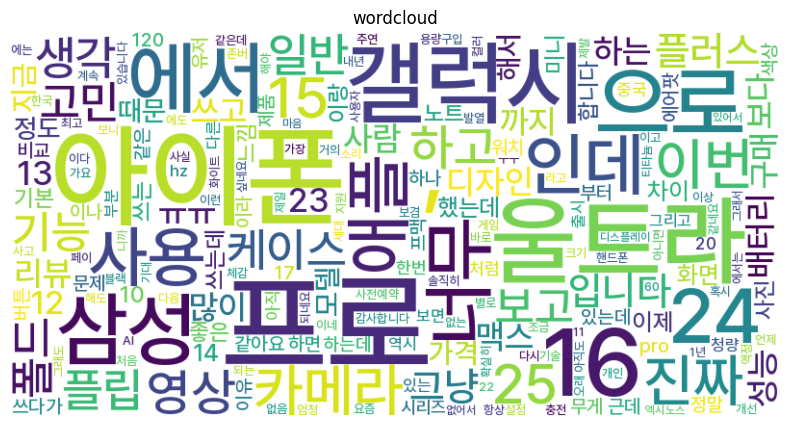

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로
font_path = 'font/Pretendard-Medium.ttf'  

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()

In [64]:
apple_df['cleaned_comment'] = apple_df['comment'].apply(cleaning_text)
apple_df['cleaned_comment'].head()

/tmp/ipykernel_2886/2092170083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['cleaned_comment'] = apple_df['comment'].apply(cleaning_text)


0                                                                                                                                                                                                                                                          플러스 사용  인데  만족 진짜
12                                                                                                                                                                                                                                  영상  조금 동떨어진 얘기 지만  23 시리즈  시점 에도 쓸만  가요 
18                                                                                                                                                                                                                      13 pro 에서 넘어갈만  가요 아이폰  부터 지금 까지 애플  써서 겔럭시  처음  보는데
40    Ai 업댓  긍정    하나  접근성  쉬워졌다는 겁니다  가끔 이미지 검색 하고 싶을  이미지  저장  거나 스샷  따로 떠서 그걸  저장 해서 구글  들어가서 이미지 검색 으로 들어가서  폴더   이미지  찾아서 확인 누르고 검색    그냥  버튼 하나 누르고 스윽   어서 검색 결과 확인     같은 프로세스  견디기 힘들어서 

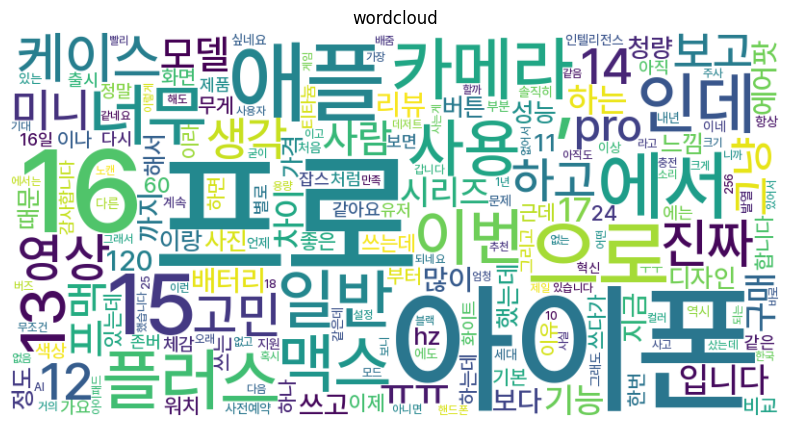

In [65]:
# 모든 리뷰의 단어를 하나의 리스트로 합치기
apple_words = apple_df['cleaned_comment'].str.split().sum()

# 단어 빈도 계산
apple_word_counts = Counter(apple_words)

# 시각화
font_path = 'font/Pretendard-Medium.ttf'  
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(apple_word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()

In [51]:
both_df['cleaned_comment'] = both_df['comment'].apply(cleaning_text)

/tmp/ipykernel_2886/2717319861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df['cleaned_comment'] = both_df['comment'].apply(cleaning_text)


In [52]:
both_df['cleaned_comment'].head()

4     애플   중국 에서 할인 해줄까  갤럭시   중국 에만 좋은걸 해줄까  그만큼 중국 먹는 기업  승자 니깐 중국 한테 좋은  다해 주는거   그리고  국민 이란 새끼   나라 먹여 살려주는 기업 개무시 하고 갤래  라고   하는데 누가 좋다고 기능 업그레이드 해줌  그동안   쓰면서 불편한거 하나  없었는데 도대체  하길래 12   집착 하는지 이해 안됨  그렇게   중요하면 가격 얼마 차이안나는 플러스 모델 사면되 겠네 
10                                                                                                                                   만든 고성능 최신  , 메모리 사다 넣고 AI 기술  발전 된거 넣은거 말고 삼성     있나 싶다  \n 전혀 새로울게 없는 , 다음 애플 신제품  피떡 되게 얻어 맞을  같은 불길한 예감  솔솔 
22                                                                                                                                                                          이어서  25시 리즈까지 거의 동결  해내네요   \n 내년  정말로 인상 할것 같으니 이번  울트라 타고 2년 존버 가겠습니다 
31                                                                                                                                                               으로 올리실  24 리뷰  안면 인식 속도 관련 리뷰 부탁드려요  22   딜레이    는데 이번  아이폰     속도 라는  사실 인지 궁금합니다 
32                  

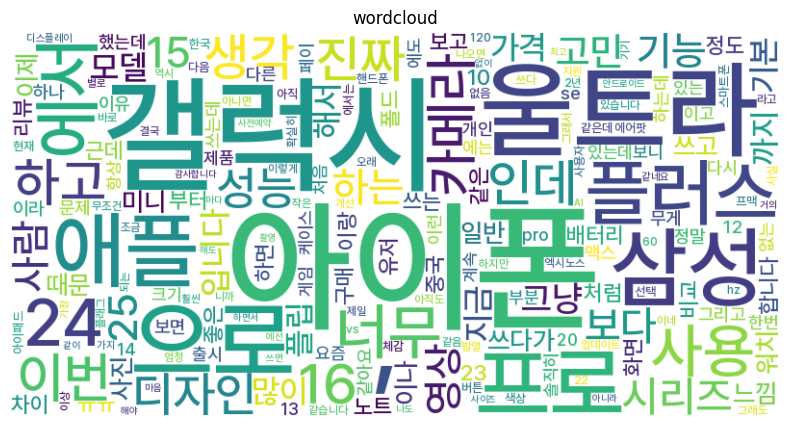

In [66]:
# 모든 리뷰의 단어를 하나의 리스트로 합치기
both_words = both_df['cleaned_comment'].str.split().sum()

# 단어 빈도 계산
both_word_counts = Counter(both_words)

# 시각화
font_path = 'font/Pretendard-Medium.ttf'  
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(both_word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()

In [67]:
neither_df['cleaned_comment'] = neither_df['comment'].apply(cleaning_text)
neither_df['cleaned_comment'].head()

/tmp/ipykernel_2886/2000145134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neither_df['cleaned_comment'] = neither_df['comment'].apply(cleaning_text)


3                               아직도    가야   20  12 기간 
6                                    노스 2400  걱정   대반 
7                                               오프닝   
8                                     출근     이라니   하네용
11    1051 실리콘 카바 이드  실리콘  카본   실리콘  카본 복합  이지 합금  아님 
Name: cleaned_comment, dtype: object

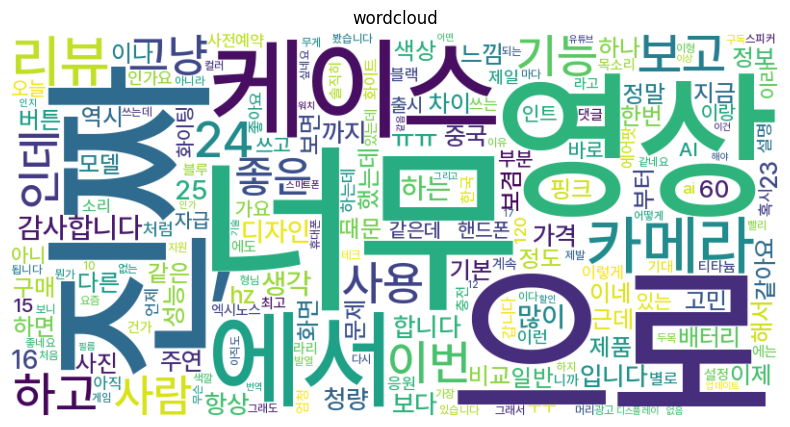

In [68]:
# 모든 리뷰의 단어를 하나의 리스트로 합치기
neither_words = neither_df['cleaned_comment'].str.split().sum()

# 단어 빈도 계산
neither_word_counts = Counter(neither_words)

# 시각화
font_path = 'font/Pretendard-Medium.ttf'  
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(neither_word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()

In [53]:
apple_df['noun'] = apple_df['comment'].apply(extract_noun)
apple_df['noun'].head()

/tmp/ipykernel_2886/2034497172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['noun'] = apple_df['comment'].apply(extract_noun)


0                                                                                                           플러스 만족
12                                                                                                  영상 조금 얘기 시점 가요
18                                                                                                   가요 아이폰 애플 겔럭시
40    업댓 긍정 접근성 가끔 이미지 검색 이미지 저장 거나 스샷 저장 구글 이미지 검색 폴더 이미지 확인 검색 버튼 스윽 어서 검색 결과 확인 프로세스 컴퓨터 거의 요즘 해도 크게 의미 기능 업댓 해
58                                                                                      아이폰 디자인 외형 내부 인터페이스 아이폰 처럼
Name: noun, dtype: object

## LLM 키워드

In [54]:
search_term = {
    "영상 제작": ["화질", "안정감", "음질", "속도", "배터리", "저장 공간", "편집"],
    "사진 촬영": ["해상도", "렌즈", "밝기", "색감", "초점", "필터", "손떨림"],
    "디지털 아트": ["터치", "색상", "부드러움", "성능", "펜", "정밀함", "앱"],
    "음악 & 사운드": ["스피커", "마이크", "노이즈", "베이스", "연결성", "편집", "저장"],
    "쇼핑 & 패션": ["화면", "결제", "색감", "가상", "검색", "리뷰", "추천"],
    "SNS & 커뮤니티": ["카메라", "공유", "필터", "영상", "알림", "댓글", "트렌드"],
    "여행 & 탐방": ["위치", "지도", "배터리", "카메라", "검색", "길찾기", "번역"],
    "모바일 게임": ["반응속도", "화면", "성능", "발열", "몰입감", "조직감", "네트워크"],
    "독서 & 필기": ["화면", "필기감", "배터리", "무게", "관리", "가독성", "저장"],
    "운동 & 건강": ["추적", "심박수", "방수", "연동", "지속력", "센서", "데이터"]
}

## 연관어 빈도수

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# 연관어 빈도
vectorizer = CountVectorizer(vocabulary=search_term['영상 제작'], ngram_range=(1, 2))
X = vectorizer.fit_transform(apple_df['noun'])

# 각 키워드의 빈도
word_frequencies = X.toarray().sum(axis=0)
frequency_df = pd.DataFrame(word_frequencies, index=vectorizer.get_feature_names_out(), columns=["Frequency"])

print(frequency_df)

       Frequency
화질            79
안정감            3
음질            37
속도            66
배터리          453
저장 공간          5
편집            25


In [56]:
apple_df.loc[apple_df['noun'].str.contains('화질'), 'cleaned_comment']

716                                                                                                                                                                                                                                                                                                                                                                              아이폰 16 프로 프로 맥스 보니 \n 아직  레드 화질 번인 현상  여전히 개선 되지 않았네요 ㅜㅜ \n 무게   함께   가지  어서 \n 고쳐졌으면 합니다 ㅠㅠ
2239                                                                                                                                                                                                                                                   15 프로 맥스 256   쓰고있고  애플스토어 20일  픽업 으로 16 프로 맥스 256   주문 했는데  20일  받는거   중이 였는데 \n  영상  니깐 취소 할까 진지하게 고민 되네  진짜 디자인  똑같고 카메라 빼면 기능  차이는 없다싶이한데  카메라  화질  보면 별로 달라진게 없네  190만원 결재 했는데 15 프맥 팔아도 80만원  쓰는거라  그냥   아낄까 고민 
3674                                                                        

In [57]:
filtered_comments = apple_df[apple_df['cleaned_comment'].str.contains('|'.join(search_term['영상 제작']))]
print(filtered_comments[['cleaned_comment']])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                          cleaned_comment
298                                                                                                                                                                                                                                                                                                                                                                                                                                         4일 전에 24 플러스  구입 했는데 속도   조선시대 보다  느린데  그럴까  
349                                                 

## KcBERT
- https://github.com/Beomi/KcBERT
- https://huggingface.co/beomi/kcbert-base

## KcELECTRA
- https://github.com/Beomi/KcELECTRA

### 모델 fine-tuning
- sangrimlee/bert-base-multilingual-cased-nsmc (네이버 영화 리뷰)
- https://github.com/alsgyu/finetunning_huggingface/blob/main/Untitled2.ipynb

### zero-shot 학습
- 별도의 라벨링 작업이 필요하지 않지만, 정확도가 높지 않을 가능성 있음

### few-shot 학습
- 소량의 라벨링된 데이터를 제공해서 모델이 감성을 학습할 수 있도록 유도

In [58]:
apple_df['cleaned_comment'].head(10)

0                                                                                                                                                                                                                                                           플러스 사용  인데  만족 진짜
12                                                                                                                                                                                                                                   영상  조금 동떨어진 얘기 지만  23 시리즈  시점 에도 쓸만  가요 
18                                                                                                                                                                                                                       13 pro 에서 넘어갈만  가요 아이폰  부터 지금 까지 애플  써서 겔럭시  처음  보는데
40     Ai 업댓  긍정    하나  접근성  쉬워졌다는 겁니다  가끔 이미지 검색 하고 싶을  이미지  저장  거나 스샷  따로 떠서 그걸  저장 해서 구글  들어가서 이미지 검색 으로 들어가서  폴더   이미지  찾아서 확인 누르고 검색    그냥  버튼 하나 누르고 스윽   어서 검색 결과 확인     같은 프로세스  견디기 힘

In [59]:
# sangrimlee/bert-base-multilingual-cased-nsmc
classifier = pipeline(
    "sentiment-analysis", model="sangrimlee/bert-base-multilingual-cased-nsmc"
)
classifier("흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나.")

config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


[{'label': 'negative', 'score': 0.9642567038536072}]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [27]:
classifier('반사 애플   정도  만들었어  호들갑 떨면서 홍보  인용 으로 쓸꺼야 ')

[{'label': 'negative', 'score': 0.9788106679916382}]

In [34]:
classifier('확실히 아이폰  이쁘긴 이쁘네요')

[{'label': 'negative', 'score': 0.5894982814788818}]

In [32]:
classifier('성능  둘째 치고 기본  , 플러스 모델  훨씬 이쁨')

[{'label': 'positive', 'score': 0.5247929096221924}]

In [33]:
classifier('아이폰 12 프로 4년 사용 하고 16 프로 왔음  레알 좋다  발열   생겨  뱌터리 오래')

[{'label': 'positive', 'score': 0.891136109828949}]

In [4]:
emojis = ''.join([char for char, value in emoji.EMOJI_DATA.items()])
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

# 특수 문자, 이모지, URL, 반복된 글자 등을 처리
def clean(x): 
    x = pattern.sub(' ', x)
    x = emoji.replace_emoji(x, replace='') 
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [21]:
apple_df['clean_text'] = apple_df['comment'].apply(clean)
print(apple_df['comment'].tail())
print(" ")
print(apple_df['clean_text'].tail())

73114                                                                                                                                                       1년 뒤……..\n\n\n\n???: “아이폰 17보다 16을 추천하는 이유!”
73139                                                                                                                                                             아이폰 시리즌 베챔 없는거 치곤  발열 저정도면 나쁘지 않은거 같은데
73142                                                                                                                                                                                     걍 아이폰 디자인인데 ㅋㅋ
73158                                                                                                                                                                                  S25플러스 블랙은 왜 뺀거야?
73168    11프로 사용자인데 120의 주사율을 느껴본 적이 없어서 굳이 16프로 대신 일반 16이나 16플러스로 갈까합니다. 그런데 16도 11프로보다 화면이 좀 크더군요. (5.8":6.1"). 차라리 핸드폰 용량을 키우는 게 낫겠다 싶고 원래 16프로 기변 대신  세이브된 금액(?)으로 아이패드 미니5를 미니6으로 바꾸는데 보탤까 생각 중

In [24]:
# nlp04/korean_sentiment_analysis_kcelectra
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "nlp04/korean_sentiment_analysis_kcelectra"
classifier = pipeline("text-classification", model=model_name)

texts = [
    "이 영화 정말 재미있었어요!",
    "서비스가 너무 나빠서 다시는 안 갈 것 같아요.",
    "아이폰 디자인은 평범해요."
]

for text in texts:
    result = classifier(text)
    print(f"텍스트: {text}")
    print(f"감성: {result[0]['label']}, 점수: {result[0]['score']:.4f}")
    print()

텍스트: 이 영화 정말 재미있었어요!
감성: 기쁨(행복한), 점수: 0.5357

텍스트: 서비스가 너무 나빠서 다시는 안 갈 것 같아요.
감성: 짜증남, 점수: 0.9178

텍스트: 아이폰 디자인은 평범해요.
감성: 슬픔(우울한), 점수: 0.6849



In [25]:
id2label = model.config.id2label
print("감성 클래스 개수:", len(id2label))
print("감성 클래스 목록:", id2label)

감성 클래스 개수: 11
감성 클래스 목록: {0: '기쁨(행복한)', 1: '고마운', 2: '설레는(기대하는)', 3: '사랑하는', 4: '즐거운(신나는)', 5: '일상적인', 6: '생각이 많은', 7: '슬픔(우울한)', 8: '힘듦(지침)', 9: '짜증남', 10: '걱정스러운(불안한)'}


In [ ]:
# KcELECTRA 모델
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, num_labels=3)


In [ ]:
# # KcBERT 모델
# model_name = "beomi/kcbert-base"

# # 토크나이저
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # 모델
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# # 입력
# texts = filtered_comments.cleaned_comment.values.tolist()
# inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# # 예측
# with torch.no_grad():
#     outputs = model(**inputs)
#     predictions = torch.softmax(outputs.logits, dim=1)

# # 결과
# for text, pred in zip(texts, predictions):
#     sentiment = "긍정" if pred[1] > pred[0] else "부정"
#     print(f"텍스트: {text}")
#     print(f"감성: {sentiment} (긍정 확률: {pred[1].item():.2f})")
#     print()

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(apple_df['cleaned_noun'])
tfidf_apple_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_apple_df)

In [ ]:
tfidf_apple_df.mean().sort_values(ascending=False).head(100)

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(apple_df['cleaned_noun'])
tfidf_samsung_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_samsung_df)

In [ ]:
tfidf_samsung_df.mean().sort_values(ascending=False).head(100)

## BERTopic
- 개념 설명 : https://wikidocs.net/162079
- 알고리즘 비교 논문
  - https://accesson.kr/kslis/assets/pdf/38798/journal-58-1-5.pdf
  - https://journal.comm.or.kr/xml/37619/37619.pdf
- 참고 블로그 : https://mz-moonzoo.tistory.com/24

### 모델 파라미터
- embedding_model : 텍스트를 고차원 벡터로 변환
- vectorizer_model : 텍스트의 단어 빈도를 기반으로 벡터화
- top_n_words : 상위 n개 단어 추출
- min_topic_size : 각 주제의 최소 크기(클러스터 크기)
- umap_model : 차원 축소
- hdbscan_model : 밀도 기반 클러스터링
- verbose=True : 로그 출력

In [ ]:
umap_model = UMAP(n_neighbors=15,
                  min_dist=0.1,
                  n_components=5,
                  random_state=42,
                  metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)
model = BERTopic(embedding_model="sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens",
                 vectorizer_model=None,
                 top_n_words=15,
                 min_topic_size=10,
                 umap_model=umap_model,
                 hdbscan_model=hdbscan_model,
                 verbose=True)

In [ ]:
topics, probs = model.fit_transform(apple_df['cleaned_noun'])
model.get_topic_info()

In [ ]:
for i in range(len(set(topics))):
    print(f"Topic {i}: {model.get_topic(i)}")

In [ ]:
# 토픽별 분포 시각화
model.visualize_topics()